**IMPORTANT TO NOTE:**
- ONCE AND FOREVER, SUPER IMPORTANT LOGIC: MU'S ARE INDIVIDUAL. VARIANCE1 IS ADDED TO VARIANCE0.


**Remarks:**
- From what i saw, "K = KVec[0]" could be deleted from the 'fdep' procedure
- i could replace "iter" with "maxiter" in the returning part of the 'fdep' functions
- 


    
    # I *STILL* DO NOT GIVE AN ANSWER FOR:
    #      1.) DIFFERENT K VALUES (IN KVEC)
    #      2.) DIFFERENT RHO VALUES (IN RhoVec)

#  - - - - - - - - -

In [1]:
import numpy as np
import math
import scipy.stats as stats
from scipy.linalg import sqrtm
import scipy
import matplotlib.pyplot as plt
import time
import datetime
import random

import numba
from numba import jit, njit
from numba.typed import List

# 1.) functions

### 1.1.) block's function 

In [3]:
# number of hypotheses should be a multiplication of the size of a single block (all blocks with the same size)
# yoter nachon - - > number of blocks is determined in RHOVEC, size of a block is determined in KVEC - and that's it.

In [51]:
# THIS IS THE FUNCTION - READY TO USE.

#RhoVec = [0.5]*number_of_blocks    # what will be the corr inside a block + number of blocks
#KVec = [5]*number_of_blocks # How many members inside each block
#nb = len(KVec)         # number of blocks

def blocks_generator(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho):

    KMax = number_block_members

    block_matrices = list()
    block_sum_matrices = list()
    block_nones = list()
    block_detfacs = list()
    block_deltas = list()
    block_invdeltas = list()

    for block in range(number_of_blocks):
        covmat_base = np.array([[Rho]*(KMax)]*(KMax)) + np.identity(KMax)*variance_0 - np.identity(KMax)*Rho
        matnow = np.array([]).reshape(0,KMax)   
        nonenow = np.array([]).reshape(1,0)  
        detfacnow = np.array([]).reshape(1,0) 
        deltnow = np.array([]).reshape(1,0)  
        invdeltnow = np.array([]).reshape(1,0)
        
        bitmask = [2**(x+1) for x in range(KMax)] # This is the bitmask saharon was asking for.
        for i in range(2**(KMax)):                # WE'RE USING i ONLY AS A NUMBER, NOT AS AN INDEX - i is perfect 100%.
            modulu_i = [i%x for x in bitmask]
            divide_2 = [x/2 for x in bitmask]
            fn = np.fromiter((modulu_i[j] >= divide_2[j] for j in range(len(bitmask))), dtype=float)
            added_diag = np.zeros(((KMax),(KMax)),float)
            np.fill_diagonal(added_diag,list(fn*variance_1))
            covmat = covmat_base + added_diag
            invmat = np.linalg.inv(covmat)            
            matnow = np.concatenate((matnow, invmat), axis=0)                          
            nonenow = np.concatenate((nonenow, np.array([fn.sum()]).reshape(1,1)), axis=1) 
            detfacnow = np.concatenate((detfacnow, np.array([np.linalg.det(covmat)**(-0.5)]).reshape(1,1)), axis=1) 
            fnmu = np.where(fn == 0, mu0, mu1)
            deltnow = np.concatenate((deltnow, np.array(fnmu).reshape(1,KMax)), axis=1) 
            invdeltnow = np.concatenate((invdeltnow, np.array(np.matmul(invmat,fnmu)).reshape(1,KMax)), axis=1)

        sum_matrix = np.array([], dtype=np.int64).reshape(0,2**(KMax))   
        
        for i in range(KMax):                       # HERE WERE USING i AS A NUMBER, AND NOT AS AN INDEX
            modulu_2i = [x%(2**(i+1)) for x in list(range(2**(KMax)))]                      
            cols = np.array([modulu_2i[k] >= (2**(i+1))/2 for k in range(len(modulu_2i))]) 
            sum_matrix = np.concatenate((sum_matrix,np.matrix(cols*1)), axis=0)        # THIS SUM_MATRIX IS ADDING CLOSED LISTS AND -NOT- CONCATING

        block_matrices.append(matnow)    
        block_sum_matrices.append(sum_matrix)
        block_nones.append(nonenow)
        block_detfacs.append(detfacnow)
        block_deltas.append(deltnow)
        block_invdeltas.append(invdeltnow)  

    block_matrices = np.array(block_matrices)
    block_sum_matrices = np.array(block_sum_matrices)
    block_nones = np.array(block_nones)
    block_detfacs = np.array(block_detfacs)
    block_deltas = np.array(block_deltas)
    block_invdeltas = np.array(block_invdeltas)

    return block_matrices, block_sum_matrices, block_nones, block_detfacs, block_deltas, block_invdeltas

In [50]:
# %%time

# # SAMPLE RUN

# variance_0 = 1
# variance_1 = 0.01
# mu0 = 0
# mu1 = -1.5

# number_of_blocks = 500  # was nb
# number_block_members = 5
# Rho = 0.5 

# block_matrices,block_sum_matrices,block_nones,block_detfacs,block_deltas,block_invdeltas = blocks_generator(mu0, 
#                                                                                                             variance_0, 
#                                                                                                             mu1, 
#                                                                                                             variance_1, 
#                                                                                                             number_of_blocks, 
#                                                                                                             number_block_members,
#                                                                                                             Rho)
# block_matrices.shape, block_sum_matrices.shape, block_nones.shape, block_detfacs.shape, block_deltas.shape, block_invdeltas.shape

[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1

[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800. 

[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800. 

[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800. 

[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1

[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5

[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800. 

[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5

[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800. 

[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5

[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5

[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5

[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 80

[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800. 

[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5

[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800. 

[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800. 

[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800. 

[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800. 

[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800. 

[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5

[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5

[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5

[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800. 

[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5

[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800. 

[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5

[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800. 

[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5

[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]
[800.  800.  800.   -1.5  -1.5]
[ -1.5 800.  800.   -1.5  -1.5]
[800.   -1.5 800.   -1.5  -1.5]
[ -1.5  -1.5 800.   -1.5  -1.5]
[800.  800.   -1.5  -1.5  -1.5]
[ -1.5 800.   -1.5  -1.5  -1.5]
[800.   -1.5  -1.5  -1.5  -1.5]
[-1.5 -1.5 -1.5 -1.5 -1.5]
[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5

[800. 800. 800. 800. 800.]
[ -1.5 800.  800.  800.  800. ]
[800.   -1.5 800.  800.  800. ]
[ -1.5  -1.5 800.  800.  800. ]
[800.  800.   -1.5 800.  800. ]
[ -1.5 800.   -1.5 800.  800. ]
[800.   -1.5  -1.5 800.  800. ]
[ -1.5  -1.5  -1.5 800.  800. ]
[800.  800.  800.   -1.5 800. ]
[ -1.5 800.  800.   -1.5 800. ]
[800.   -1.5 800.   -1.5 800. ]
[ -1.5  -1.5 800.   -1.5 800. ]
[800.  800.   -1.5  -1.5 800. ]
[ -1.5 800.   -1.5  -1.5 800. ]
[800.   -1.5  -1.5  -1.5 800. ]
[ -1.5  -1.5  -1.5  -1.5 800. ]
[800.  800.  800.  800.   -1.5]
[ -1.5 800.  800.  800.   -1.5]
[800.   -1.5 800.  800.   -1.5]
[ -1.5  -1.5 800.  800.   -1.5]
[800.  800.   -1.5 800.   -1.5]
[ -1.5 800.   -1.5 800.   -1.5]
[800.   -1.5  -1.5 800.   -1.5]
[ -1.5  -1.5  -1.5 800.   -1.5]

KeyboardInterrupt: 

### 1.2.) RBETA function

In [3]:
def rbeta_generator (mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter):
    
    K = number_block_members
    
    a = np.full((maxiter, number_of_blocks,1,K,K), (np.array([Rho]*number_of_blocks)*variance_0)[0])
    print("A")
    b = np.full((maxiter, number_of_blocks,1,K,K), np.identity(K)*(1 - np.array(Rho)))
    print("b")
    new_h = np.array([np.array([np.full((1,1,K),np.random.binomial(1, p=prob_to_1, size=K)) for i in range(number_of_blocks)]) for i in range(maxiter)])
    print("new_h")
    new_c = np.array([np.array([np.full((1,K,K), np.identity(K)) for i in range(number_of_blocks)]) for i in range(maxiter)])
    print("new_c")
    c = new_c * new_h * variance_1
    covmat = (a+b)*variance_0 + c
    sqrtmat = np.real(np.array([np.array([sqrtm(covmat[j][i][0]) for i in range(covmat.shape[1])]).reshape(number_of_blocks,1,K,K) for j in range(covmat.shape[0])]).reshape(maxiter,number_of_blocks,1,K,K))
    print("sqrtmat")
    new_h_mus = np.where(new_h == 0, mu0, mu1)
    beta = np.array([np.array([np.matmul(sqrtmat[j][i][0],np.random.normal(0,1,K)) for i in range(number_of_blocks)]) for j in range(maxiter)]) + (new_h_mus).reshape(maxiter,number_of_blocks,K)
    print("beta")
    
    return list(beta), new_h.reshape(maxiter,number_of_blocks,K)

In [5]:
# FOR A SAMPLE RUN

variance_0 = 1
variance_1 = 0.01
mu0 = 0
mu1 = -1.5

number_of_blocks = 1000 # was nb
number_block_members = 5
Rho = 0.5  

prob_to_1 = 0.3
maxiter = 5 # 5000 

In [52]:
%%time

# A SAMPLE RUN

first_try, new_h = rbeta_generator (mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

A
b


ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [5]:
# np.save('first_try', first_try)

In [7]:
# first_try_ = np.load('first_try.npy')
# first_try_.shape

## 1.3.) AandB function split

In [4]:
def AandB_locfdr_generator (block_beta, number_of_blocks, number_block_members, prob_to_1, maxiter, 
                            block_matrices, block_deltas, block_invdeltas, block_sum_matrices, block_nones, block_detfacs):
    
    vec_len = number_of_blocks
    K = number_block_members
    
    # S1_1
    block_matrices_vec = np.full((maxiter, vec_len, block_matrices.shape[1], K), block_matrices)
    block_beta_vec = np.asarray(block_beta).reshape(maxiter, vec_len, K, 1)
    S1_1 = np.matmul(block_matrices_vec, block_beta_vec).reshape(maxiter, vec_len, 1, block_matrices.shape[1])

    # S1_2
    deltas_bet_vec = np.full((maxiter, vec_len, 1, block_deltas.shape[2]), 2 * block_deltas)
    deltas_bet_reshape = deltas_bet_vec.reshape(maxiter, vec_len,int(block_deltas.shape[2]/K), K)
    block_beta_vec = np.array(block_beta).reshape(maxiter,vec_len,1,K)                     
    S1_2 = (block_beta_vec - deltas_bet_reshape).reshape(maxiter, vec_len, 1, block_deltas.shape[2])

    # S1_3
    S1_3 = np.full((maxiter,block_deltas.shape[0],block_deltas.shape[1],block_deltas.shape[2]), block_deltas*block_invdeltas)
    S1 = S1_1 * S1_2 + S1_3
    M1_before_T = S1.reshape(maxiter, vec_len, int(block_deltas.shape[2]/K), K)
    M1 = np.transpose(M1_before_T, axes=(0,1,3,2))    
    
    # pzh
    block_detfacs_vec = np.full((maxiter, block_detfacs.shape[0], block_detfacs.shape[1], block_detfacs.shape[2]),block_detfacs)
    pzh_1 = block_detfacs_vec * np.exp(M1.sum(axis=2)*(-0.5)).reshape(maxiter, vec_len, 1, int(block_deltas.shape[2]/K))
    block_nones_vec = np.full((maxiter, block_nones.shape[0], block_nones.shape[1], block_nones.shape[2]), block_nones)
    pzh_2 = (prob_to_1**block_nones_vec) * ((1-prob_to_1)**(K - block_nones_vec))
    pzh = pzh_1*pzh_2
    
    # locfdr
    block_sum_matrices_vec = np.full((maxiter, block_sum_matrices.shape[0], block_sum_matrices.shape[1], block_sum_matrices.shape[2]), block_sum_matrices)
    numerator =  np.matmul(block_sum_matrices_vec, pzh.reshape(maxiter, vec_len,pzh.shape[3],1))      #mone
    denominator = np.sum(pzh,axis=3)[:,:,None]                                                        #mechane  #.shape i need it to be (50,10,1,1)
    locfdr = np.array([np.concatenate((1 - (numerator / denominator))[i]) for i in range(maxiter)])
    
    return locfdr
    
### NOT RELEVANT ANYMORE : : : 

# def AandB_a_and_b_generator (locfdr, maxiter):
    
#     K = locfdr.shape[1]
#     locFDR = np.sort(locfdr, axis=1).reshape(locfdr.shape[0], locfdr.shape[1])

#     clocFDR = np.cumsum(locFDR, axis=1)
#     a = 1-locFDR

#     b_1 = locFDR / np.array(range(1,K+1))

#     zeros = np.full((maxiter,1),np.array([0]))
#     clocFDR_b2 = np.delete(clocFDR,-1,1)
#     b_2 = np.append(zeros, clocFDR_b2 / np.array(range(1,K)) / np.array(range(2,K+1)),axis=1)

#     b = b_1 - b_2

#     return a, b, np.transpose(locfdr,axes=(0,2,1)), locFDR

In [5]:
def AandB_locfdr_generator_optimizer(block_beta, number_of_blocks, number_block_members, prob_to_1, maxiter, 
                                     block_matrices, block_deltas, block_invdeltas, block_sum_matrices, block_nones, block_detfacs):
    
    # dividing the process into loops of 625 iterations (it was 1250 (5 places), checking if it's possible)
    
    locfdr_optimizer = []
    
    loop_times = maxiter//1250
    if maxiter%1250 > 0:
        loop_times += 1
    for i in range(loop_times):
        print("loop no.: " + str(i))
        iterations = 1250
        iter_block_beta = block_beta[i*iterations:(i+1)*iterations]
        
        if (i == loop_times-1) and (maxiter%1250 > 0):
            iterations = maxiter%1250
            iter_block_beta = block_beta[-iterations:]
        
        locfdr = AandB_locfdr_generator (block_beta = iter_block_beta, 
                                         number_of_blocks = number_of_blocks, 
                                         number_block_members = number_block_members, 
                                         prob_to_1 = prob_to_1, 
                                         maxiter = iterations, 
                                         block_matrices = block_matrices, 
                                         block_deltas = block_deltas, 
                                         block_invdeltas = block_invdeltas, 
                                         block_sum_matrices = block_sum_matrices, 
                                         block_nones = block_nones, 
                                         block_detfacs = block_detfacs)        
        locfdr_optimizer.append(locfdr)

    return np.concatenate(locfdr_optimizer,axis=0)
 

In [158]:
# # FOR A SAMPLE RUN

# variance_0 = 1
# variance_1 = 0.01
# mu0 = 0
# mu1 = -1.5

# number_of_blocks = 1000 # was nb
# number_block_members = 5
# Rho = 0.5  

# prob_to_1 = 0.3
# maxiter = 5000 

In [13]:
# %%time

# # A SAMPLE RUN

# locfdr = AandB_locfdr_generator_optimizer (first_try_, number_of_blocks, number_block_members, prob_to_1, maxiter, block_matrices, block_deltas, block_invdeltas, block_sum_matrices, block_nones, block_detfacs)
# locfdr.shape

loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
Wall time: 5min 45s


(5000, 5000, 1)

In [14]:
# aa,bb,lcfdr,sorted_lcfdr = AandB_a_and_b_generator (locfdr, maxiter)
# aa,bb,lcfdr,sorted_lcfdr

(array([[9.98902572e-01, 9.98819028e-01, 9.98197912e-01, ...,
         3.38011653e-04, 2.67815242e-04, 2.35953638e-04],
        [9.98021211e-01, 9.97659759e-01, 9.97273589e-01, ...,
         2.72500777e-04, 2.34334043e-04, 1.73150034e-04],
        [9.99799166e-01, 9.99057755e-01, 9.98924000e-01, ...,
         2.44421203e-04, 1.47716307e-04, 1.36740611e-04],
        ...,
        [9.99118129e-01, 9.98778723e-01, 9.98674263e-01, ...,
         3.57275111e-04, 2.67142942e-04, 2.65120280e-04],
        [9.99368690e-01, 9.97898829e-01, 9.97678225e-01, ...,
         2.98907578e-04, 2.65334408e-04, 1.61721827e-04],
        [9.99880294e-01, 9.99584919e-01, 9.99520219e-01, ...,
         4.75109936e-04, 3.81878210e-04, 1.03197358e-04]]),
 array([[1.09742806e-03, 4.17719042e-05, 2.20962515e-04, ...,
         6.00545878e-05, 6.00446032e-05, 6.00269577e-05],
        [1.97878875e-03, 1.80726089e-04, 1.88965292e-04, ...,
         5.86260456e-05, 5.86102254e-05, 5.85990181e-05],
        [2.00834298e-04, 

## 1.4.) locfdr generator

In [6]:
def locfdr_generator_all_groups(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter):
    
    locfdr_holder = []
    h_holder = []
    for i in range(len(mu0)):
            
        # 1.) BLOCKS
        print(" * * * BLOCKS START: ")
        start = time.time()   
        block_matrices, block_sum_matrices, block_nones, block_detfacs, block_deltas, block_invdeltas = blocks_generator (mu0[i], 
                                                                                                                    variance_0[i], 
                                                                                                                    mu1[i], 
                                                                                                                    variance_1[i], 
                                                                                                                    number_of_blocks[i], 
                                                                                                                    number_block_members[i],
                                                                                                                    Rho[i])
        stop = time.time()
        duration = stop-start
        print(" * * * BLOCKS time: " + str(duration))
        
        # 2.) RBETA 
        print(" * * * BLOCK BETA START: ")
        start = time.time()   
        block_beta, new_h = rbeta_generator (mu0[i], variance_0[i], mu1[i], variance_1[i], number_of_blocks[i], number_block_members[i], Rho[i], prob_to_1[i], maxiter)
        stop = time.time()
        duration = stop-start
        print(" * * * BLOCK BETA time: " + str(duration))
        
        # 3.) loc fdr: Optimizer(AandB)
        print(" * * * AANDB LOCFDR GENERATOR START: ")
        start = time.time()   
        locfdr = AandB_locfdr_generator_optimizer (block_beta, number_of_blocks[i], number_block_members[i], prob_to_1[i], maxiter, block_matrices, block_deltas, block_invdeltas, block_sum_matrices, block_nones, block_detfacs)
        stop = time.time()
        duration = stop-start
        print(" * * * AANDB LOCFDR GENERATOR time: " + str(duration))
        
        locfdr_holder.append(locfdr)
        h_holder.append(new_h)
        
    return locfdr_holder, h_holder

def locfdr_concator(locfdr_master):
    list_concat_locfdr = []
    for i in range(len(locfdr_master)):
        list_concat_locfdr.append(locfdr_master[i])
    return np.concatenate(list_concat_locfdr, axis=1)

def vec_h_concator(vec_h):
    list_vec_h = []
    for i in range(len(vec_h)):
        block_to_group_array = np.array([np.concatenate(vec_h[i][j]) for j in range(len(vec_h[i]))])
        list_vec_h.append(block_to_group_array)
    return np.concatenate(list_vec_h, axis=1)




In [38]:
# %%time
# masterlocfdr, new_h = locfdr_generator_all_groups(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
# masterlocfdr_ = locfdr_concator(masterlocfdr)
# new_h_ = vec_h_concator(new_h)

 * * * BLOCKS START: 
BLOCKS time: 2.3415398597717285
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 0.6773819923400879
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.04686474800109863
 * * * BLOCKS START: 
BLOCKS time: 1.8588523864746094
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 0.4537982940673828
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.046831607818603516
Wall time: 5.43 s


## 1.5.) slfdr decision rule & V & FNR

In [7]:
def SLFDR_decision_vectorized_rule(olocfdr, alpha):
    
    locfdr_cumsum = np.cumsum(olocfdr, axis=1).reshape(len(olocfdr),len(olocfdr[0]))
    ranks_vec = np.full((len(olocfdr),len(olocfdr[0])),np.array(list(range(1, len(olocfdr[0])+1))))
    rule_sums = locfdr_cumsum / ranks_vec
    
    num_rejections_list = []
    rejections_olocfdr_list = []
    
    for iter in range(len(olocfdr)):
        num_rejections = olocfdr[iter][olocfdr[iter] < alpha].shape[0]
        rejections_olocfdr = olocfdr[iter][:num_rejections]

        num_rejections_list.append(num_rejections)
        rejections_olocfdr_list.append(rejections_olocfdr)
        
    return num_rejections_list, rejections_olocfdr_list


In [36]:
#olocfdr[iter][olocfdr[iter] < alpha].shape[0]

oded = [np.array([1,2,3,4,5,6]),np.array([56,67,78,999])]
oded[0][oded[0] < 1].shape[0]

0

In [8]:
# num_rejections_list, rejections_olocfdr_list = SLFDR_decision_vectorized_rule(masterlocfdr__, 0.05)

In [8]:
def V_generator(locfdr_, vec_h_, num_rejections_list):
    
    # INPUT: original locfdr, original vec_h, number of rejections
    # OUTPUT: A list of "V" per iteration for maxiter
    
    #1. take the "marglocfdr" & "vec_h" , enumerate it as a dictionary 
    marglocfdr_d = [dict(enumerate(locfdr_[i])) for i in range(len(locfdr_))]
    vec_h_d = [dict(enumerate(vec_h_[i])) for i in range(len(vec_h_))]
    
    #2. sort the locfdr (values), so that their index (keys) is shuffeled
    omarglocfdr_d = [dict(sorted(marglocfdr_d[i].items(), key=lambda x: x[1])) for i in range(len(marglocfdr_d))]

    #3. take only the "num_rejections" first SHUFFELED indexes from "omarglocfdr_d"
    first_indexes = [list(omarglocfdr_d[i].keys())[:num_rejections_list[i]] for i in range(len(omarglocfdr_d))]

    #4. take only the "first_indexes" indexes from the enumerated vec_h dictionary, the vector of their values: "values_h"
    final_h = [dict([(k, vec_h_d[i][k]) for k in first_indexes[i]]) for i in range(len(vec_h_d))]

    #5. V = num_rejections - sum(values_h)
    V = [num_rejections_list[i] - sum(final_h[i].values()) for i in range(len(final_h))]

    return V

#V_ = V_generator(masterlocfdr_, new_h_, num_rejections_list)


In [9]:
def FNR(num_hypo, prob_to_1, R_mean, V_mean):
    
    # calculating number of non-nulls + total number of hypotheses
    non_nulls = 0
    total_num_hypo = 0
    for i in range(len(num_hypo)):
        non_nulls += num_hypo[i]*prob_to_1[i]
        total_num_hypo += num_hypo[i]

    return (non_nulls - R_mean + V_mean) / (total_num_hypo - R_mean)

## 1.6.) R & S

#### Bcpp is ONLY for the marginals, so we got only "D" to deal with now

In [10]:
# MARCH 2022 Version of dcpp - numba version:
def DCpp_numba(R):
    K=len(R)
    D=[0]*K
    cR=0

    i=0
    while i<K:
        cR=0
        j=i
        while j<K:
            cR+=R[j]
            if cR>0:
                D[i]=1
                j+=1    # I think that this one is useless
                break
            j+=1
        if D[i]==0:
            i+=1
            break    
        i+=1
    return D

In [11]:
DCpp_numba_jit = jit()(DCpp_numba)

In [12]:
# MARCH 2022 version with new JITTED D function
def FDR_Generic_structure (mus, a, b_1, b_2, ind, lev_mat, pow_mat, minprob_mat, ev_mat, er_mat, olocfdr_function, alpha = 0.05):
    for mui in range(len(mus)):                ##### we use "mui" as an INDEX
        mu = mus[mui]
        Rz = a-mu*b_1
        if (ind == 1) | (ind == 4):
            Rz[0] = Rz[0] + mu*alpha
        Rz_numba = numba.typed.List(Rz)
        Dz = list(DCpp_numba_jit(Rz_numba))
        indices_ab = [i for i, x in enumerate(Dz) if x == 1]
        sum_b = sum([b_2[j] for j in indices_ab])
        ### if sum_b <0: # it's here because u had a problem with that
        lev_mat[mui, ind] = lev_mat[mui,ind] + sum_b 
        sum_a = sum([a[j] for j in indices_ab])  
        pow_mat[mui, ind] = pow_mat[mui,ind] + sum_a 
        minprob_mat[mui, ind] = minprob_mat[mui,ind] + Dz[0] 
        sum_oloc = sum([olocfdr_function[j] for j in indices_ab])
        ev_mat[mui, ind] = ev_mat[mui, ind] + sum_oloc 
        er_mat[mui, ind] = er_mat[mui, ind] + sum(Dz) 
    return lev_mat, pow_mat, minprob_mat, ev_mat, er_mat

In [13]:
def AandB_a_and_b_generator (locfdr, maxiter):
    
    K = locfdr.shape[1]
    locFDR = np.sort(locfdr, axis=1).reshape(locfdr.shape[0], locfdr.shape[1])
    
    clocFDR = np.cumsum(locFDR, axis=1)
    a = 1-locFDR

    b_1 = locFDR / np.array(range(1,K+1))

    zeros = np.full((maxiter,1),np.array([0]))
    clocFDR_b2 = np.delete(clocFDR,-1,1)
    b_2 = np.append(zeros, clocFDR_b2 / np.array(range(1,K)) / np.array(range(2,K+1)), axis=1)

    b = b_1 - b_2

    return a, b, locFDR

In [14]:
def fdep_ORACLE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha):

    # "columns order: OMTFDR, OMTpFDR, OMTmFDR ... "
    minprob_mat = np.zeros((1,3),float)
    lev_mat = np.zeros((1,3),float)
    pow_mat = np.zeros((1,3),float)
    ev_mat = np.zeros((1,3),float)
    er_mat = np.zeros((1,3),float)  
    
    # - - - for oracle rule - - -
    a, b, locFDR = AandB_a_and_b_generator (olocfdr_packed, maxiter)
    
    for iter in range(maxiter): 

        # OMTFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=0, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)      
         # OMTpFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musPFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=1, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)    
        # OMTMFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = FDR_Generic_structure (mus=musMFDR, 
                                                                               a=a[iter-1], 
                                                                               b_1=locFDR[iter] - alpha, 
                                                                               b_2=b[iter], 
                                                                               ind=2, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)                  

    return lev_mat/maxiter, pow_mat/maxiter, minprob_mat/maxiter, ev_mat/maxiter, er_mat/maxiter



## 1.7.) The general mother 

In [53]:
def the_general_mother(musFDR, musPFDR, musMFDR, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter):
    
    # initialize
    num_hypo = list(np.array(number_of_blocks) * np.array(number_block_members))
     
    ############################################################ 1.) Generating locfdr & vec_h per group, as a List
    locfdr_unpacked, vec_h_unpacked = locfdr_generator_all_groups(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
    
    ############################################################ 2.) SLFDR 
    SLFDR_R = []
    SLFDR_V = []
    for group in range(len(locfdr_unpacked)):
        SLFDR_olocfdr = np.sort(locfdr_unpacked[group], axis=1)
        num_rejections, rejections_olocfdr = SLFDR_decision_vectorized_rule(SLFDR_olocfdr, alpha)
        vec_h_per_group = np.array([np.concatenate(vec_h_unpacked[group][j]) for j in range(len(vec_h_unpacked[group]))])
        v = V_generator(locfdr_unpacked[group], vec_h_per_group, num_rejections)
        SLFDR_R.append(num_rejections)
        SLFDR_V.append(v)
    SLFDR_MINPROB = np.where(sum((np.array(SLFDR_R) > 0) + 0) > 1, 1, 0)        
    
    # 2.1.) Calculating the procedure's metrics
    SLFDR_POWER = np.mean(np.sum(SLFDR_R, axis = 0) - np.sum(SLFDR_V, axis = 0))
    a = np.sum(SLFDR_V, axis = 0)
    b = np.sum(SLFDR_R, axis = 0)
    SLFDR_FDR_DIVIDE = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b!=0)
    SLFDR_FDR = np.mean(SLFDR_FDR_DIVIDE) 
    if np.mean(np.sum(SLFDR_R, axis = 0)) != 0:
        SLFDR_MFDR = np.mean(np.sum(SLFDR_V, axis = 0)) / np.mean(np.sum(SLFDR_R, axis = 0))
    else:
        SLFDR_MFDR = 0  
    if np.mean(SLFDR_MINPROB) != 0:
        SLFDR_PFDR = SLFDR_FDR / np.mean(SLFDR_MINPROB)
    else:
        SLFDR_PFDR = 0
    SLFDR_FNR = FNR(num_hypo, prob_to_1, np.mean(np.sum(SLFDR_R, axis = 0)), np.mean(np.sum(SLFDR_V, axis = 0)))
    
    slfdr_list = [SLFDR_POWER, SLFDR_FNR, SLFDR_FDR, SLFDR_MFDR, SLFDR_PFDR]
    ############################################################ 3.) packing locfdr & vec_h together for the rest 4 procedures 
    locfdr_packed = locfdr_concator(locfdr_unpacked)
    vec_h_packed = vec_h_concator(vec_h_unpacked)
    olocfdr_packed = np.sort(locfdr_packed, axis=1)
    
    ############################################################ 4.) CLFDR
    CLFDR_R, rejections_olocfdr_list = SLFDR_decision_vectorized_rule(olocfdr_packed, alpha)
    CLFDR_V = V_generator(locfdr_packed, vec_h_packed, CLFDR_R)
    CLFDR_MINPROB = (np.array(CLFDR_R) > 0) + 0
    
    # 4.1.) Calculating the procedure's metrics
    CLFDR_POWER = np.mean(np.array(CLFDR_R) - np.array(CLFDR_V))
    aa = np.array(CLFDR_V)
    bb = np.array(CLFDR_R)
    CLFDR_FDR_DIVIDE = np.divide(aa, bb, out=np.zeros(aa.shape, dtype=float), where=bb!=0)
    CLFDR_FDR = np.mean(CLFDR_FDR_DIVIDE)
    if np.mean(CLFDR_R) != 0:
        CLFDR_MFDR = np.mean(CLFDR_V) / np.mean(CLFDR_R)
    else:
        CLFDR_MFDR = 0
    if np.mean(CLFDR_MINPROB) != 0:
        CLFDR_PFDR = CLFDR_FDR / np.mean(CLFDR_MINPROB)
    else:
        CLFDR_PFDR = 0
    CLFDR_FNR = FNR(num_hypo, prob_to_1, np.mean(CLFDR_R), np.mean(CLFDR_V))
    
    clfdr_list = [CLFDR_POWER, CLFDR_FNR, CLFDR_FDR, CLFDR_MFDR, CLFDR_PFDR]
    
    ############################################################ 5.) R&S
    lev_mat_r, pow_mat_r, minprob_mat_r, ev_mat_r, er_mat_r = fdep_ORACLE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha)
    
    # 5.1.) OMTFDR control
    OMTFDR_power = pow_mat_r[0][0]
    OMTFDR_fdr = lev_mat_r[0][0]
    OMTFDR_mfdr = ev_mat_r[0][0] / er_mat_r[0][0]
    OMTFDR_pfdr = lev_mat_r[0][0] / minprob_mat_r[0][0]
    OMTFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][0], ev_mat_r[0][0]) 
    
    OMTFDR_list = [OMTFDR_power, OMTFDR_fnr, OMTFDR_fdr, OMTFDR_mfdr, OMTFDR_pfdr]
    
    # 5.2.) OMTpFDR control
    OMTpFDR_power = pow_mat_r[0][1]
    OMTpFDR_fdr = lev_mat_r[0][1]
    OMTpFDR_mfdr = ev_mat_r[0][1] / er_mat_r[0][1]
    OMTpFDR_pfdr = lev_mat_r[0][1] / minprob_mat_r[0][1]
    OMTpFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][1], ev_mat_r[0][1]) 
    
    OMTpFDR_list = [OMTpFDR_power, OMTpFDR_fnr, OMTpFDR_fdr, OMTpFDR_mfdr, OMTpFDR_pfdr]
    
    # 5.3.) OMTmFDR control
    OMTmFDR_power = pow_mat_r[0][2]
    OMTmFDR_fdr = lev_mat_r[0][2]
    OMTmFDR_mfdr = ev_mat_r[0][2] / er_mat_r[0][2]
    OMTmFDR_pfdr = lev_mat_r[0][2] / minprob_mat_r[0][2]
    OMTmFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][2], ev_mat_r[0][2]) 
    
    OMTmFDR_list = [OMTmFDR_power, OMTmFDR_fnr, OMTmFDR_fdr, OMTmFDR_mfdr, OMTmFDR_pfdr]

    return slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list


In [ ]:
locfdr_unpacked = [group 1 locfdr from db, group 2 locfdr from db]
vec_h_unpacked = [vec h 1 from db, vec h 2 from db]

def the_general_mother_database(locfdr_unpacked, vec_h_unpacked, musFDR, musPFDR, musMFDR, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter):
    
    # initialize
    num_hypo = list(np.array(number_of_blocks) * np.array(number_block_members))
     
    ############################################################ 1.) Generating locfdr & vec_h per group, as a List
    # no longer needed because of db :)
    
    ############################################################ 2.) SLFDR 
    SLFDR_R = []
    SLFDR_V = []
    for group in range(len(locfdr_unpacked)):
        SLFDR_olocfdr = np.sort(locfdr_unpacked[group], axis=1)
        num_rejections, rejections_olocfdr = SLFDR_decision_vectorized_rule(SLFDR_olocfdr, alpha)
        vec_h_per_group = np.array([np.concatenate(vec_h_unpacked[group][j]) for j in range(len(vec_h_unpacked[group]))])
        v = V_generator(locfdr_unpacked[group], vec_h_per_group, num_rejections)
        SLFDR_R.append(num_rejections)
        SLFDR_V.append(v)
    SLFDR_MINPROB = np.where(sum((np.array(SLFDR_R) > 0) + 0) > 1, 1, 0)        
    
    # 2.1.) Calculating the procedure's metrics
    SLFDR_POWER = np.mean(np.sum(SLFDR_R, axis = 0) - np.sum(SLFDR_V, axis = 0))
    a = np.sum(SLFDR_V, axis = 0)
    b = np.sum(SLFDR_R, axis = 0)
    SLFDR_FDR_DIVIDE = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b!=0)
    SLFDR_FDR = np.mean(SLFDR_FDR_DIVIDE) 
    if np.mean(np.sum(SLFDR_R, axis = 0)) != 0:
        SLFDR_MFDR = np.mean(np.sum(SLFDR_V, axis = 0)) / np.mean(np.sum(SLFDR_R, axis = 0))
    else:
        SLFDR_MFDR = 0  
    if np.mean(SLFDR_MINPROB) != 0:
        SLFDR_PFDR = SLFDR_FDR / np.mean(SLFDR_MINPROB)
    else:
        SLFDR_PFDR = 0
    SLFDR_FNR = FNR(num_hypo, prob_to_1, np.mean(np.sum(SLFDR_R, axis = 0)), np.mean(np.sum(SLFDR_V, axis = 0)))
    
    slfdr_list = [SLFDR_POWER, SLFDR_FNR, SLFDR_FDR, SLFDR_MFDR, SLFDR_PFDR]
    ############################################################ 3.) packing locfdr & vec_h together for the rest 4 procedures 
    locfdr_packed = locfdr_concator(locfdr_unpacked)
    vec_h_packed = vec_h_concator(vec_h_unpacked)
    olocfdr_packed = np.sort(locfdr_packed, axis=1)
    
    ############################################################ 4.) CLFDR
    CLFDR_R, rejections_olocfdr_list = SLFDR_decision_vectorized_rule(olocfdr_packed, alpha)
    CLFDR_V = V_generator(locfdr_packed, vec_h_packed, CLFDR_R)
    CLFDR_MINPROB = (np.array(CLFDR_R) > 0) + 0
    
    # 4.1.) Calculating the procedure's metrics
    CLFDR_POWER = np.mean(np.array(CLFDR_R) - np.array(CLFDR_V))
    aa = np.array(CLFDR_V)
    bb = np.array(CLFDR_R)
    CLFDR_FDR_DIVIDE = np.divide(aa, bb, out=np.zeros(aa.shape, dtype=float), where=bb!=0)
    CLFDR_FDR = np.mean(CLFDR_FDR_DIVIDE)
    if np.mean(CLFDR_R) != 0:
        CLFDR_MFDR = np.mean(CLFDR_V) / np.mean(CLFDR_R)
    else:
        CLFDR_MFDR = 0
    if np.mean(CLFDR_MINPROB) != 0:
        CLFDR_PFDR = CLFDR_FDR / np.mean(CLFDR_MINPROB)
    else:
        CLFDR_PFDR = 0
    CLFDR_FNR = FNR(num_hypo, prob_to_1, np.mean(CLFDR_R), np.mean(CLFDR_V))
    
    clfdr_list = [CLFDR_POWER, CLFDR_FNR, CLFDR_FDR, CLFDR_MFDR, CLFDR_PFDR]
    
    ############################################################ 5.) R&S
    lev_mat_r, pow_mat_r, minprob_mat_r, ev_mat_r, er_mat_r = fdep_ORACLE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha)
    
    # 5.1.) OMTFDR control
    OMTFDR_power = pow_mat_r[0][0]
    OMTFDR_fdr = lev_mat_r[0][0]
    OMTFDR_mfdr = ev_mat_r[0][0] / er_mat_r[0][0]
    OMTFDR_pfdr = lev_mat_r[0][0] / minprob_mat_r[0][0]
    OMTFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][0], ev_mat_r[0][0]) 
    
    OMTFDR_list = [OMTFDR_power, OMTFDR_fnr, OMTFDR_fdr, OMTFDR_mfdr, OMTFDR_pfdr]
    
    # 5.2.) OMTpFDR control
    OMTpFDR_power = pow_mat_r[0][1]
    OMTpFDR_fdr = lev_mat_r[0][1]
    OMTpFDR_mfdr = ev_mat_r[0][1] / er_mat_r[0][1]
    OMTpFDR_pfdr = lev_mat_r[0][1] / minprob_mat_r[0][1]
    OMTpFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][1], ev_mat_r[0][1]) 
    
    OMTpFDR_list = [OMTpFDR_power, OMTpFDR_fnr, OMTpFDR_fdr, OMTpFDR_mfdr, OMTpFDR_pfdr]
    
    # 5.3.) OMTmFDR control
    OMTmFDR_power = pow_mat_r[0][2]
    OMTmFDR_fdr = lev_mat_r[0][2]
    OMTmFDR_mfdr = ev_mat_r[0][2] / er_mat_r[0][2]
    OMTmFDR_pfdr = lev_mat_r[0][2] / minprob_mat_r[0][2]
    OMTmFDR_fnr = FNR(num_hypo, prob_to_1, er_mat_r[0][2], ev_mat_r[0][2]) 
    
    OMTmFDR_list = [OMTmFDR_power, OMTmFDR_fnr, OMTmFDR_fdr, OMTmFDR_mfdr, OMTmFDR_pfdr]

    return slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list


In [28]:
def plot_metric(metric_index, metric_tite_str, metric_realizations_x_axis, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR):
    # this function needs as an input a series of NESTED LISTS per policy procedure
    
    slfdr_metric_list = [policy_realization[metric_index] for policy_realization in slfdr]
    clfdr_metric_list = [policy_realization[metric_index] for policy_realization in clfdr]
    rs_OMTFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_OMTFDR]
    rs_OMTpFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_OMTpFDR]
    rs_OMTmFDR_metric_list = [policy_realization[metric_index] for policy_realization in rs_OMTmFDR]
        
    plt.plot(metric_realizations_x_axis, slfdr_metric_list , label = "slfdr")
    plt.plot(metric_realizations_x_axis, clfdr_metric_list , label = "clfdr")
    plt.plot(metric_realizations_x_axis, rs_OMTFDR_metric_list , label = "OMTFDR")
    plt.plot(metric_realizations_x_axis, rs_OMTpFDR_metric_list , label = "OMTpFDR")
    plt.plot(metric_realizations_x_axis, rs_OMTmFDR_metric_list , label = "OMTmFDR")


    plt.title(metric_tite_str)
    plt.legend()
    plt.show()

def plot_4_metrics(simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR):
    # this function needs: the output of the 5 procedures + the X axis simulations change
    
    plot_metric(0, "Power - E(TP)", simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR)
    plot_metric(1, "FNR", simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR)
    plot_metric(2, "FDR", simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR)
    plot_metric(3, "mFDR", simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR)
    plot_metric(4, "pFDR", simulation, slfdr, clfdr, rs_OMTFDR, rs_OMTpFDR, rs_OMTmFDR)

In [30]:
# locfdr_unpacked, vec_h_unpacked = locfdr_generator_all_groups(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

 * * * BLOCKS START: 
BLOCKS time: 2.4015772342681885
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 0.6213424205780029
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.057099103927612305
 * * * BLOCKS START: 
BLOCKS time: 1.845036268234253
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 0.5134193897247314
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.03989386558532715


## 1.8.) simulations

In [18]:
alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 1]
mu0 = [0, 0]
mu1 = [-1.5, 1]

number_of_blocks = [1000, 800] 
number_block_members = [5, 5]
Rho = [0.5, 0.5]  

prob_to_1 = [0.3, 0.2]
maxiter = 5 #5000 


In [19]:
# OLD
#%%time

# maxiter = 5: 5.78 sec
# maxiter = 50: 19 sec
# maxiter = 500: 2 min 39 sec
# maxiter = 5000 will be probably around 23 min

#rejections_olocfdr_list, num_rejections_list, v_list, minprob_list = the_general_mother(alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
#rejections_olocfdr_list, num_rejections_list, v_list, minprob_list

TypeError: the_general_mother() missing 3 required positional arguments: 'Rho', 'prob_to_1', and 'maxiter'

In [119]:
%%time
maxiter = 5000
S, C = the_general_mother(alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
S, C

 * * * BLOCKS START: 
BLOCKS time: 2.259986162185669
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 571.3525121212006
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
AANDB LOCFDR GENERATOR time: 378.1015269756317
 * * * BLOCKS START: 
BLOCKS time: 2.044093370437622
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 452.6669509410858
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
AANDB LOCFDR GENERATOR time: 266.3546073436737
Wall time: 36min 39s


([284.542, 0.022734313284114717, 0.022741853720726082, 0.022734313284114717],
 [1422710.0, 0.02274185372072608, 0.02274185372072608, 0.02274185372072608])

In [159]:
%%time
maxiter = 20
S, C = the_general_mother(alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
S, C

 * * * BLOCKS START: 
BLOCKS time: 2.488187551498413
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 2.681450128555298
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.21941304206848145
 * * * BLOCKS START: 
BLOCKS time: 1.7778267860412598
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 1.7984645366668701
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 0.14876866340637207
Wall time: 11 s


([281.7,
  0.2316889080212369,
  0.024300379235982838,
  0.024415584415584415,
  0.024300379235982838],
 [281.7,
  0.2316889080212369,
  0.024300379235982838,
  0.024415584415584415,
  0.024300379235982838])

In [164]:
%%time

maxiter = 250
p1_simulation = np.arange(0, 0.5, 0.05).tolist()

slfdr = []
clfdr = []

for p1 in p1_simulation:
    
    prob_to_1 = [p1, 0.1]
    
    slfdr_list, clfdr_list = the_general_mother(alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
    
    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)


 * * * BLOCKS START: 
BLOCKS time: 2.255709171295166
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 27.670564651489258
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 4.474195957183838
 * * * BLOCKS START: 
BLOCKS time: 1.8368251323699951
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 22.229430675506592
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 3.5769128799438477


C:\Users\ahron\AppData\Local\Temp/ipykernel_16048/1190326715.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  SLFDR_PFDR = SLFDR_FDR / np.mean(SLFDR_MINPROB)


 * * * BLOCKS START: 
BLOCKS time: 2.123771905899048
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 27.44517159461975
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 4.638456106185913
 * * * BLOCKS START: 
BLOCKS time: 1.7435197830200195
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 22.09201407432556
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 3.6387577056884766
 * * * BLOCKS START: 
BLOCKS time: 2.1469428539276123
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 27.550033807754517
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 4.6367363929748535
 * * * BLOCKS START: 
BLOCKS time: 1.7316741943359375
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
BLOCK BETA time: 22.044304132461548
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
AANDB LOCFDR GENERATOR time: 3.759154796600342
 * * * BLOCKS START: 
BLOCKS time

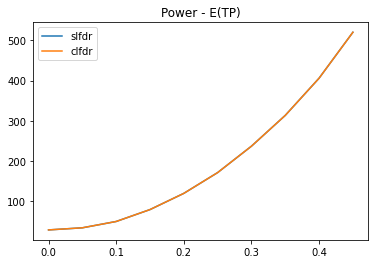

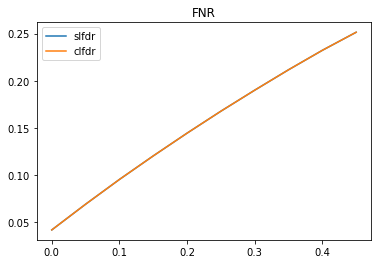

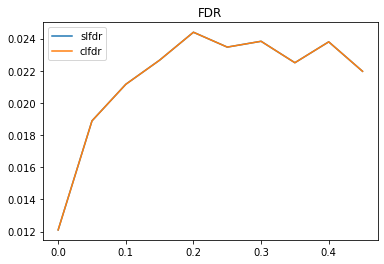

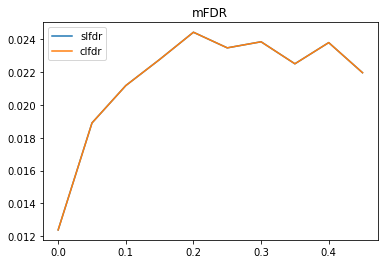

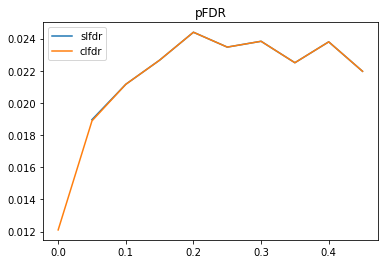

In [166]:
plot_4_metrics(p1_simulation, slfdr, clfdr) #, rs_margFDR, rs_margpFDR, rs_margmFDR)

In [109]:
%%time

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 1]
mu0 = [0, 0]
mu1 = [-1.5, 1]

number_of_blocks = [1000, 800] #[1000, 800] 
number_block_members = [5, 5] #[5, 5]
Rho = [0.5, 0.5]  

prob_to_1 = [0.3, 0.2]

#maxiter = 50 - 23sec 
#maxiter = 500 - 3 min 28 sec
#maxiter = 5000 - 41 min

musMargFDR_scalar = [7090.5]   # between 1432.3160887391211 to 1419.
musMargPFDR_scalar = [6650.56]
musMargMFDR_scalar = [13.373] 

maxiter = 5000

slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list = the_general_mother(musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar,alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list 

 * * * BLOCKS START: 
 * * * BLOCKS time: 2.366732597351074
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 599.1270625591278
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 386.7949140071869
 * * * BLOCKS START: 
 * * * BLOCKS time: 1.9244921207427979
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 451.68201661109924
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 268.4445753097534
Wall time: 41min 2s


([284.6442,
  0.23141206203899142,
  0.02201904759412516,
  0.022013308998554207,
  0.02201904759412516],
 [284.6442,
  0.23141206203899142,
  0.02201904759412516,
  0.022013308998554207,
  0.02201904759412516],
 [543.6244510414688,
  0.20845995900798514,
  0.053218922569783396,
  0.05377364581975558,
  0.053218922569783396],
 [594.0721950586476,
  0.20388065178949197,
  0.06056679693648947,
  0.061072505698236836,
  0.06056679693648947],
 [519.4589058372877,
  0.2106242208097826,
  0.04999579779253077,
  0.04998900618664762,
  0.04999579779253077])

In [54]:
%%time

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 1]
mu0 = [0, 0]
mu1 = [-1.5, 1]

number_of_blocks = [1000, 800] #[1000, 800] 
number_block_members = [5, 5] #[5, 5]
Rho = [0.5, 0.5]  

prob_to_1 = [0.3, 0.2]

musMargFDR_scalar = [7090.5]   # between 1432.3160887391211 to 1419.
musMargPFDR_scalar = [6650.56]
musMargMFDR_scalar = [13.373] 

maxiter = 50 #0
#p1_simulation = np.arange(0, 0.5, 0.05).tolist()
p1_simulation = [0.2, 0.3]

slfdr = []
clfdr = []
rs_margFDR = []
rs_margpFDR = []
rs_margmFDR = []

for p1 in p1_simulation:
    
    prob_to_1 = [p1, 0.1]
    
    #slfdr_list, clfdr_list = the_general_mother(alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
    slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list = the_general_mother(musMargFDR_scalar, musMargPFDR_scalar, musMargMFDR_scalar,alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_margFDR.append(OMTFDR_list)
    rs_margpFDR.append(OMTpFDR_list)
    rs_margmFDR.append(OMTmFDR_list)

 * * * BLOCKS START: 
 * * * BLOCKS time: 2.4838578701019287
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 6.205187797546387
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
 * * * AANDB LOCFDR GENERATOR time: 0.6104750633239746
 * * * BLOCKS START: 
 * * * BLOCKS time: 1.9679241180419922
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 4.999640703201294
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
 * * * AANDB LOCFDR GENERATOR time: 0.4672727584838867
TIME IT TOOK FOR locfdr generator to RUN: 16.736374378204346
TIME IT TOOK FOR ALL OF SLFDR TO RUN: 2.4122612476348877
TIME IT TOOK FOR EVERYTHING SINCE FINISH OF SLFDR TO RUN: 5.6867218017578125
 * * * BLOCKS START: 
 * * * BLOCKS time: 2.487640857696533
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 6.076044321060181
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
 * * * AANDB LOCFDR GENERATOR time: 0.6083285808563232
 * * * BLOCKS STA

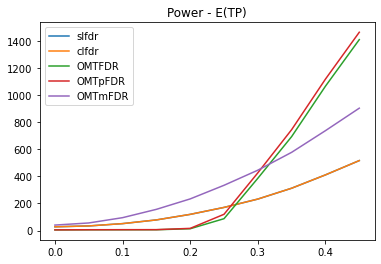

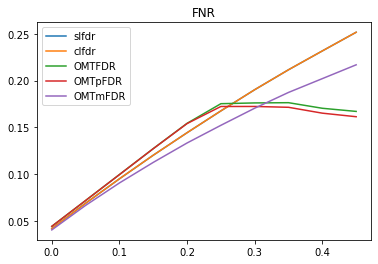

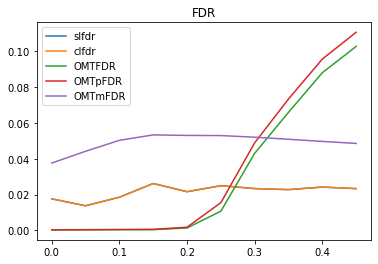

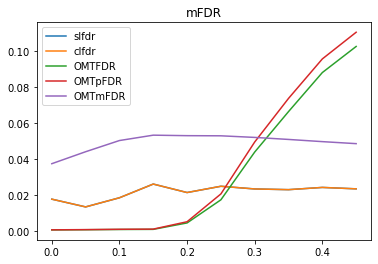

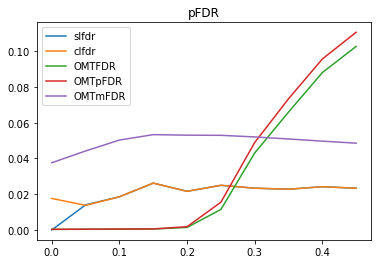

In [44]:
plot_4_metrics(p1_simulation, slfdr, clfdr, rs_margFDR, rs_margpFDR, rs_margmFDR)

# 2.) building the right setting

In [ ]:
### R & S SETTING:

### ONCE AND FOREVER, SUPER IMPORTANT LOGIC: MU'S ARE INDIVIDUAL. VARIANCE1 IS ADDED TO VARIANCE0.


alpha = 0.05

number_of_blocks = [1000]
number_block_members = [5]

prob_to_1 = [0.3]
variance_0 = [1]
variance_1 = [0.01]
mu0 = [0]
mu1 = [-1.5]

# THE ONLY THING THAT CHANGES IT "RHO"
Rho = [0.5]                # 0, 0.1, 0.5


## 2.1.) 5 Possible settings, 2 groups, based on r&s base setting for 1 group

In [ ]:
### same group (different size), same rho

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]
mu0 = [0, 0]
mu1 = [-1.5, -1.5]

number_of_blocks = [1000, 800]
number_block_members = [5, 5]
Rho = [0.5, 0.5]  

prob_to_1 = [0.3, 0.3]

In [ ]:
### same group (different size), different rho 1#

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]
mu0 = [0, 0]
mu1 = [-1.5, -1.5]

number_of_blocks = [1000, 800] 
number_block_members = [5, 5] 
Rho = [0.5, 0.1]  

prob_to_1 = [0.3, 0.3]

In [ ]:
### same group (different size), different rho 2#

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]
mu0 = [0, 0]
mu1 = [-1.5, -1.5]

number_of_blocks = [1000, 800]  
number_block_members = [5, 5] 
Rho = [0.5, 0]  

prob_to_1 = [0.3, 0.3]

In [ ]:
### different mu1 per group (different size), same rho

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]
mu0 = [0, 0]
mu1 = [-1.5, 1.5]

number_of_blocks = [1000, 800] 
number_block_members = [5, 5] 
Rho = [0.5, 0.5]  

prob_to_1 = [0.3, 0.3]

In [ ]:
### different mu1 per group (different size), different rho

alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]
mu0 = [0, 0]
mu1 = [-1.5, 1.5]

number_of_blocks = [1000, 800]
number_block_members = [5, 5] 
Rho = [0.5, 0]  

prob_to_1 = [0.3, 0.2]